# Домашнее задание № 2

### Автор: Кузнецов С.И.

**Задание:** Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import boxcox
import matplotlib.pyplot as plt
%matplotlib inline

Загружаем ряд *monthly-us-auto-registration-tho*

In [2]:
auto_registration = pd.read_csv('monthly-us-auto-registration-tho.csv', sep = ';')
auto_registration_series = auto_registration['Monthly U.S. auto registration (thousands) 1947 ? 1968']

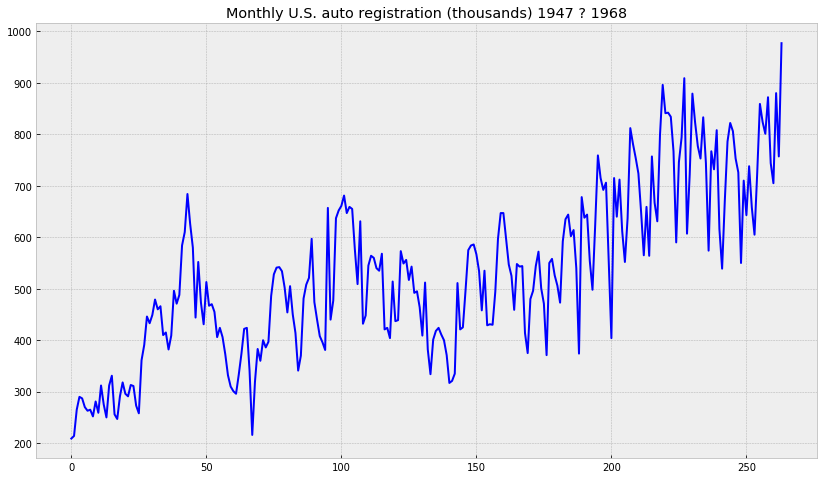

In [3]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(auto_registration_series, color='blue',label='original')
    plt.title('Monthly U.S. auto registration (thousands) 1947 ? 1968')

#### 1. Нестационарный ряд

Т.к. ряд имеет сезонность с периодом 12 (см дз №1, HW1.ipynb), то для предсказания будем использовать метод Хольта-Винтерса.

In [4]:
def initial_trend(series, season_len, i = 3):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [5]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [6]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [7]:
def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

Используя кросс-валидацию подберем оптимальное значение параметров. Качество модели будем измерять с помощью метрики *RMSE*

Пусть первые 200 точек - тренировочная выборка, а все последующие - тестовая.

In [8]:
train, val = auto_registration_series[:250], auto_registration_series[250:]

In [9]:
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=5) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

In [10]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [11]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 7.579088269878512e-08
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.74334946e-06, -7.55945295e-06,  4.14754262e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 196
      nit: 40
   status: 0
  success: True
        x: array([0.0451391 , 0.24121687, 0.95995856])


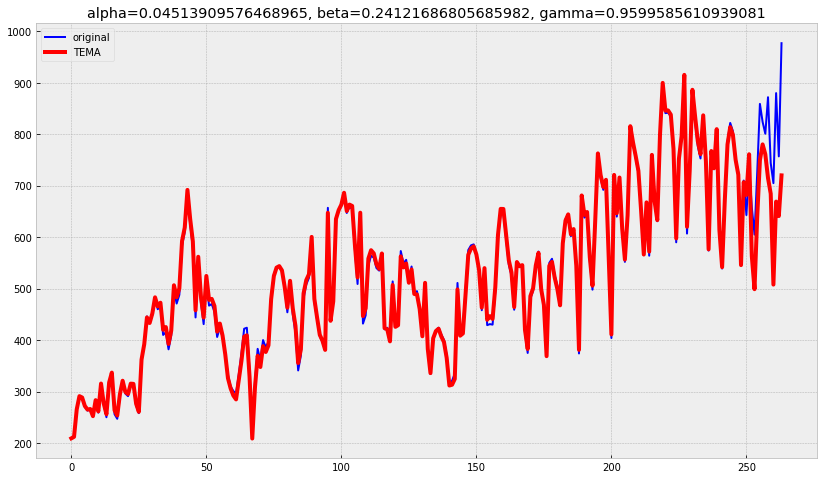

In [12]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=auto_registration_series, n_preds=len(val))

Проверим качество модели

In [13]:
predict = triple_exponential_smoothing(series = auto_registration_series, 
                                       slen = 12, 
                                       alpha = alpha_opt, 
                                       beta = beta_opt, 
                                       gamma = gamma_opt, 
                                       n_preds=len(val))

In [14]:
 mean_squared_error(predict[250:len(auto_registration_series)], auto_registration_series[250:])

10.927825158001687

#### 2. Стационарный ряд

In [15]:
auto_registration_stat = boxcox(auto_registration_series, 0)
auto_registration_stat = auto_registration_stat[1:] - auto_registration_stat[:-1]
auto_registration_stat = auto_registration_stat[12:] - auto_registration_stat[:-12]

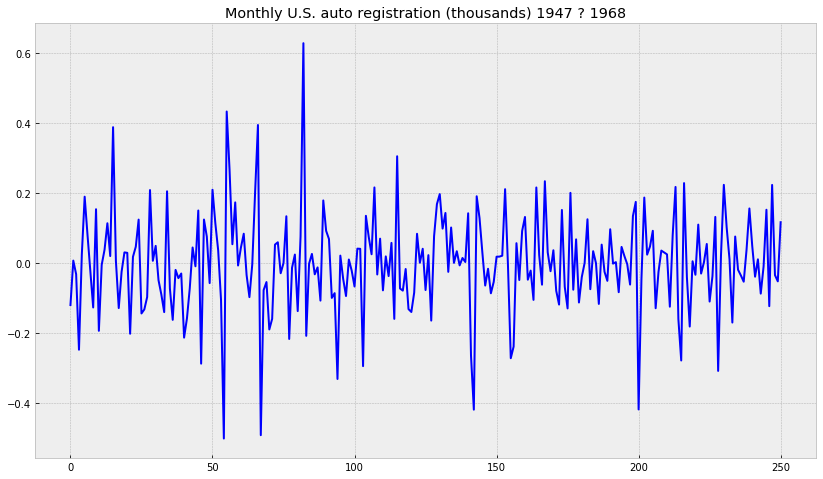

In [16]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(auto_registration_stat, color='blue',label='original')
    plt.title('Monthly U.S. auto registration (thousands) 1947 ? 1968')

Поскольку ряд не содержит ни тренда, ни сезонности и стоит задача получить оптимальное приближение ряда, будем применять экспоненциальное сглаживание.

In [17]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

Попробуем сгладить с разными параметрами

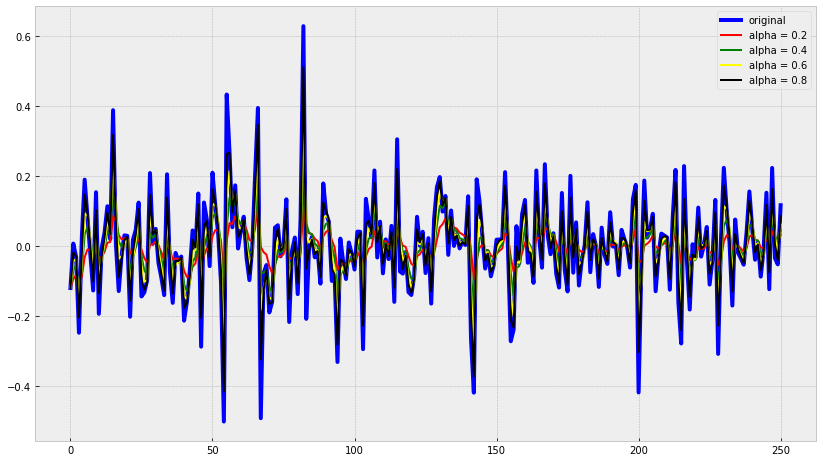

In [18]:
ema_02 = exponential_moving_average(auto_registration_stat, 0.2)
ema_04 = exponential_moving_average(auto_registration_stat, 0.4)
ema_06 = exponential_moving_average(auto_registration_stat, 0.6)
ema_08 = exponential_moving_average(auto_registration_stat, 0.8)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(auto_registration_stat, linewidth='4', color='blue',label='original')
    plt.plot(ema_02, color='red', linewidth='2', label='alpha = 0.2')
    plt.plot(ema_04, color='green', linewidth='2', label='alpha = 0.4')
    plt.plot(ema_06, color='yellow', linewidth='2', label='alpha = 0.6')
    plt.plot(ema_08, color='black', linewidth='2', label='alpha = 0.8')
    plt.legend()

Оценим качество приближения

In [19]:
ema = {0.2: ema_02,
       0.4: ema_04,
       0.6: ema_06,
       0.8: ema_08,
      }

for k, v in ema.items():
    print('alpha = {:.2}, RMSE = {:.4}'.format(k, mean_squared_error(v, auto_registration_stat)))

alpha = 0.2, RMSE = 0.01501
alpha = 0.4, RMSE = 0.009752
alpha = 0.6, RMSE = 0.005033
alpha = 0.8, RMSE = 0.001472


Мы видим, что при увеличении параметра сглаживания повышается точность. Но поскольку ставилась задача отследить тенденции, то лучше всего для этих целей подходит alpha = 0.2, несмотря на не самую высокую точность предсказания

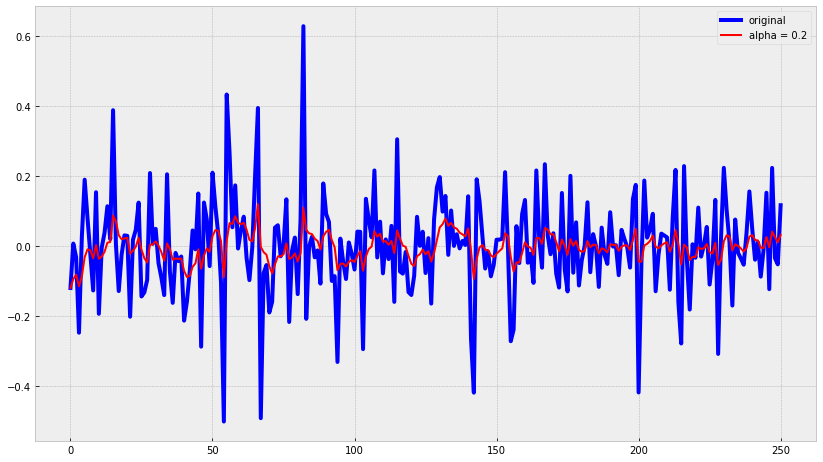

In [20]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(auto_registration_stat, linewidth='4', color='blue',label='original')
    plt.plot(ema_02, color='red', linewidth='2', label='alpha = 0.2')
    plt.legend()